# License

***

Copyright 2018-2019 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Partial Dependence, Individual Conditional Expectation, and Surrogate Models

#### Start H2O cluster


The `os` commands below check whether this notebook is being run on the Aquarium platform. 

In [1]:
import os

startup = '/home/h2o/bin/aquarium_startup'
if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
    !sleep 5
else:
    local_url = 'http://localhost:54321'
    aquarium = False

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and H2o and XGBoost will be used for modeling tasks.

In [2]:
# for handling external processes to generate PNG file of decision tree
import time
import sys
import re
import subprocess

# in-notebook display of decision tree
from IPython.display import Image
from IPython.display import display

# to generate synthetic data w/ known interactions
from data_maker_and_getter import DataMakerAndGetter

import h2o                                                        # Python API for h2o library and server 
from h2o.estimators.random_forest import H2ORandomForestEstimator # h2o, for single tree
from h2o.backend import H2OLocalServer                            # h2o, for plotting local tree in-notebook

import matplotlib.pyplot as plt                                   # basic plotting
%matplotlib inline

import numpy as np                                                # basic math and array and matrix handling 
import pandas as pd                                               # basic Dataframe handling
import xgboost as xgb                                             # for training gradient boosting machines 

# ignore irrelevant warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 2, but the server still needs to be started.

>The parameters used in `h2o.init` will depend on your specific environment. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

In [3]:
#h2o.init(url=local_url, max_mem_size='2G')
h2o.init(max_mem_size='2G')
h2o.remove_all()    # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 mins 39 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 13 days
H2O cluster name:,H2O_from_python_unknownUser_z1oo7r
H2O cluster total nodes:,1
H2O cluster free memory:,13.43 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


#### Dataset with Known Signal Generating Functions

Create dataset with a known signal generating function with noise: 

$$ y = x_1 * x_4 + |x_8| * (x_9)^2 + e $$

## Data Generation and XGBoost Training

Generate synthetic data with:
* 200,000 rows
* Binary target
* A single, known signal-generating function (see above)
* With noise via label switching

In [4]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function=True, noise=True)
rson = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Histogram of important variable in generated data

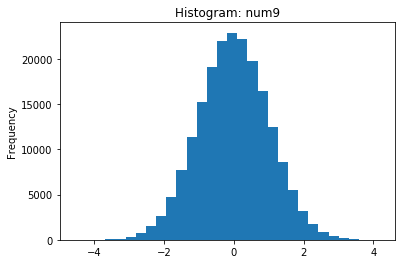

In [5]:
rson_pd = rson.as_data_frame()
_ = rson_pd['num9'].plot(kind='hist', bins=30, title='Histogram: num9')

#### Assign modeling roles

In [6]:
y = 'target'
X = [name for name in rson.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


#### Split data into training and validation set

In [7]:
rson[y] = rson[y].asfactor()
train, valid, _ = rson.split_frame([0.4, 0.3], seed = 12345)
print(train.shape)
print(valid.shape)

(80049, 18)
(59947, 18)


#### Convert h2o frame into Pandas Dataframe for various activites below

In [8]:
rsontrain_pd = train.as_data_frame()
rsonvalid_pd = valid.as_data_frame()

#### Convert Pandas Dataframes into XGBoost DMatrices (LightSVM format), required for training XGBoost

In [9]:
rsontrain_dm = xgb.DMatrix(rsontrain_pd[X],
                           rsontrain_pd[y])
rsonvalid_dm = xgb.DMatrix(rsonvalid_pd[X],
                           rsonvalid_pd[y])

#### Use average of y as XGBoost null model

In [10]:
ave_y = rsontrain_pd['target'].mean()
print(ave_y)

0.42154180564404303


#### Train XGBoost GBM
Hyperparameters selected by Cartesian grid search: https://gist.github.com/jphall663/705595e3bc72e8fdfee8fa56220503a5

In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsontrain_dm, 'train'), (rsonvalid_dm, 'eval')]

rson_model = xgb.train(params, 
                       rsontrain_dm, 
                       400,
                       early_stopping_rounds=50,
                       evals=watchlist, 
                       verbose_eval=True)

[0]	train-auc:0.6399	eval-auc:0.616491
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.762294	eval-auc:0.73553
[2]	train-auc:0.781428	eval-auc:0.751339
[3]	train-auc:0.809046	eval-auc:0.779411
[4]	train-auc:0.81321	eval-auc:0.780589
[5]	train-auc:0.817244	eval-auc:0.782645
[6]	train-auc:0.827766	eval-auc:0.794141
[7]	train-auc:0.831464	eval-auc:0.798754
[8]	train-auc:0.834837	eval-auc:0.801459
[9]	train-auc:0.8367	eval-auc:0.802674
[10]	train-auc:0.838219	eval-auc:0.804488
[11]	train-auc:0.840738	eval-auc:0.807931
[12]	train-auc:0.842619	eval-auc:0.810168
[13]	train-auc:0.844455	eval-auc:0.811907
[14]	train-auc:0.845956	eval-auc:0.813274
[15]	train-auc:0.846862	eval-auc:0.814184
[16]	train-auc:0.84782	eval-auc:0.814579
[17]	train-auc:0.848815	eval-auc:0.814493
[18]	train-auc:0.849401	eval-auc:0.815477
[19]	train-auc:0.84996	eval-auc:0.816238
[20]	train-auc:0.850676	eval-auc:0.81

[191]	train-auc:0.876096	eval-auc:0.821668
[192]	train-auc:0.8762	eval-auc:0.821618
[193]	train-auc:0.876273	eval-auc:0.82163
[194]	train-auc:0.876294	eval-auc:0.821638
[195]	train-auc:0.876363	eval-auc:0.821649
[196]	train-auc:0.876519	eval-auc:0.821698
[197]	train-auc:0.876562	eval-auc:0.821688
[198]	train-auc:0.876667	eval-auc:0.821608
[199]	train-auc:0.876789	eval-auc:0.821595
[200]	train-auc:0.8769	eval-auc:0.821598
[201]	train-auc:0.87701	eval-auc:0.821642
[202]	train-auc:0.877035	eval-auc:0.821657
[203]	train-auc:0.877205	eval-auc:0.82163
[204]	train-auc:0.877353	eval-auc:0.821744
[205]	train-auc:0.877465	eval-auc:0.821722
[206]	train-auc:0.877528	eval-auc:0.821736
[207]	train-auc:0.877609	eval-auc:0.821732
[208]	train-auc:0.877839	eval-auc:0.821764
[209]	train-auc:0.877894	eval-auc:0.821763
Stopping. Best iteration:
[159]	train-auc:0.873198	eval-auc:0.821932



## Calculate and Display Partial Dependence and ICE Curves

#### Function for calculating partial dependence and ICE

In [12]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [13]:
par_dep_num9 = par_dep('num9', rsonvalid_pd[X], rson_model)

#### Display partial dependence for important variable

In [14]:
par_dep_num9

,num9,partial_dependence
0,-4.080806,0.702345
1,-3.682671,0.702345
2,-3.284536,0.702345
3,-2.886401,0.702973
4,-2.488266,0.713698
5,-2.090131,0.674772
6,-1.691996,0.648410
7,-1.293861,0.560577
8,-0.895725,0.452450
9,-0.497590,0.312965


#### Bind XGBoost predictions to training data and display

In [15]:
rson_preds = pd.DataFrame(rson_model.predict(rsonvalid_dm))
rson_decile_frame = pd.concat([rsonvalid_pd, rson_preds], axis=1)
rson_decile_frame = rson_decile_frame.rename(columns={0: 'predict'})
rson_decile_hframe = h2o.H2OFrame(rson_decile_frame)
rson_decile_frame.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.282839
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.795540
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,1,0.553774
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,1,0.163221
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,1,10,1,0.222245


#### Find percentiles of XGBoost predictions

In [16]:
rson_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rson_decile_hframe)

#### Display percentiles with row identifiers

In [17]:
rson_percentile_dict

{0: 9595,
 99: 183094,
 10: 17971,
 20: 75937,
 30: 51908,
 40: 34714,
 50: 179646,
 60: 149635,
 70: 83732,
 80: 161267,
 90: 189020}

#### Calculate ICE curve values

In [18]:
# retreive bins from original partial dependence calculation
bins_num9 = list(par_dep_num9['num9'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(rson_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num9[col_name] = par_dep('num9', 
                                     rsonvalid_pd[rsonvalid_pd['row_id'] == int(rson_percentile_dict[i])][X], 
                                     rson_model, 
                                     bins=bins_num9)['partial_dependence']


#### Display partial dependence and ICE for num9 -- all calculated DIRECTLY from the XGBoost model

In [19]:
par_dep_num9

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.080806,0.702345,0.532851,0.438892,0.453063,0.747858,0.695964,0.583039,0.700925,0.603205,0.770713,0.727518,0.866058
1,-3.682671,0.702345,0.532851,0.438892,0.453063,0.747858,0.695964,0.583039,0.700925,0.603205,0.770713,0.727518,0.866058
2,-3.284536,0.702345,0.532851,0.438892,0.453063,0.747858,0.695964,0.583039,0.700925,0.603205,0.770713,0.727518,0.866058
3,-2.886401,0.702973,0.531202,0.441293,0.449011,0.749916,0.698304,0.585406,0.704402,0.605822,0.770713,0.733007,0.865289
4,-2.488266,0.713698,0.560243,0.435514,0.459859,0.775133,0.716191,0.580576,0.707260,0.629715,0.775000,0.748380,0.866028
5,-2.090131,0.674772,0.434400,0.367611,0.367092,0.770793,0.674280,0.490480,0.702654,0.619553,0.788107,0.733309,0.865935
6,-1.691996,0.648410,0.314964,0.319902,0.317465,0.770622,0.634514,0.385547,0.698442,0.582801,0.791993,0.750276,0.893277
7,-1.293861,0.560577,0.242720,0.249619,0.266965,0.536126,0.410891,0.274009,0.628971,0.431951,0.774010,0.740879,0.865674
8,-0.895725,0.452450,0.200829,0.262772,0.266114,0.418927,0.247726,0.274346,0.583149,0.255119,0.719534,0.735081,0.809419
9,-0.497590,0.312965,0.183863,0.190989,0.195502,0.254960,0.210587,0.213730,0.319303,0.189143,0.666563,0.763500,0.717365


#### Plot partial dependence and ICE

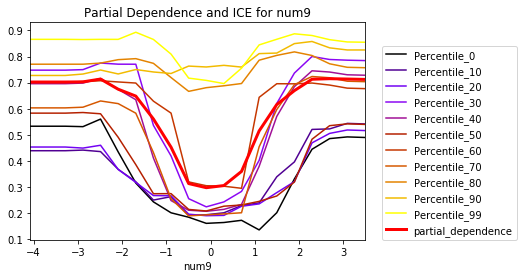

In [20]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

plot_par_dep_ICE('num9', par_dep_num9)

Notice the divergence of the ICE curves from the red partial dependence curve for `~-1 < num9 < ~1`. This divergence can be indicative of an interaction between input variables. The surrogate tree at the bottom of the notebook can provide further insight into which input variables are driving the detected interaction.

## Train and Display Surrogate Decision Tree

#### Train single h2o decision tree as surrogate between the XGBoost predictions and inputs

In [21]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=5,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=rson_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/h2o/dev/xai_guidelines/dt_surrogate_mojo.zip


#### Create GraphViz dot file of tree

In [22]:
# title for plot
title = 'Known Signal Data (with Validation) Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/h2o/bin/miniconda3/envs/h2o/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/h2o/bin/miniconda3/envs/h2o/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/h2o/dev/xai_guidelines/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Known Signal Data (with Validation) Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [23]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Display surrogate tree in-notebook
Double click to zoom.

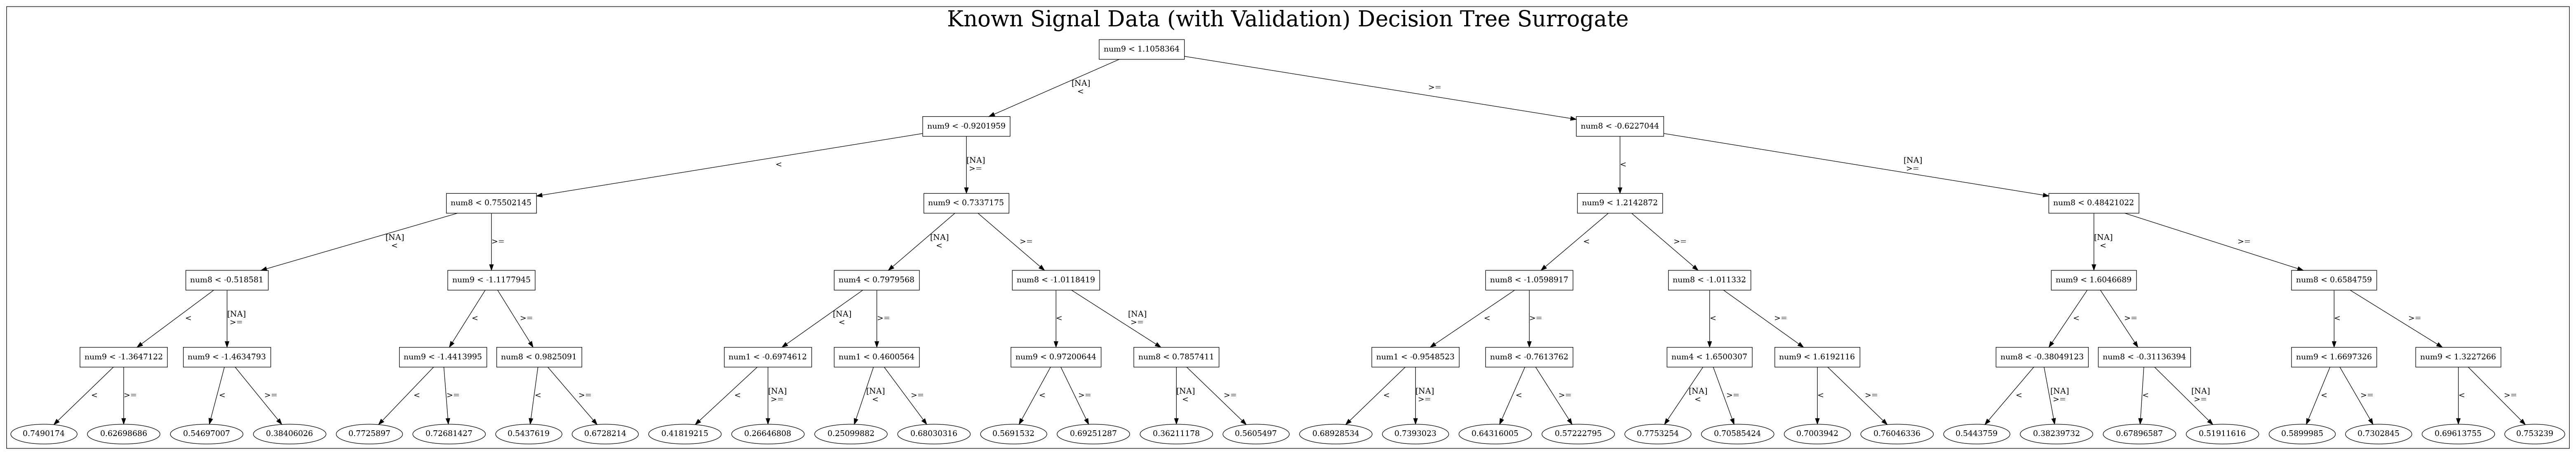

In [24]:
display(Image((png_file_name)))

In the decision tree above, there are parent-child node relationships between num9 and several other input variables for the range `~-1 < num9 < ~1`. These parent-child relationships can be indicative of the variables driving the interactions detected in the partial dependence and ICE plot above.

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models and H2OFrames, or scoring artifacts, such as POJOs and MOJOs.

In [25]:
# be careful, this can erase your work!
h2o.cluster().shutdown()

H2O session _sid_b57b closed.


**Conclusion**: In this notebook, direct and indirect model explanation techniques were combined to gain insights into the behavior of a complex ML model. 